In [2]:
import os
import argparse
from PIL import Image
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [4]:
class Interpolate(nn.Module):
    def __init__(self, scale_factor=2):
        super().__init__()
        self.scale_factor = scale_factor

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor)
        return x

trans = transforms.Compose([transforms.ToTensor()])
## Normalised VGG RELU_5_1 Encoder
normalised_vgg_relu5_1 = nn.Sequential(
    nn.Conv2d(3, 3, 1),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, 3),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, 3),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, 3),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, 3),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, 3),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, 3),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, 3),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, 3),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, 3),
    nn.ReLU())

## Normalised VGG RELU_5_1 Decoder
vgg_decoder_relu5_1 = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, 3),
    nn.ReLU(),
    Interpolate(2),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, 3),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, 3),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, 3),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, 3),
    nn.ReLU(),
    Interpolate(2),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, 3),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, 3),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, 3),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, 3),
    nn.ReLU(),
    Interpolate(2),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, 3),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, 3),
    nn.ReLU(),
    Interpolate(2),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, 3),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, 3))

In [5]:
class NormalisedVGG(nn.Module):
    def __init__(self, pretrained_path='vgg_normalised_conv5_1.pth'):
        super().__init__()
        self.net = normalised_vgg_relu5_1
        if pretrained_path is not None:
            self.net.load_state_dict(torch.load(pretrained_path, map_location=lambda storage, loc: storage))

    def forward(self, x, target):
        if target == 'relu1_1':
            return self.net[:4](x)
        elif target == 'relu2_1':
            return self.net[:11](x)
        elif target == 'relu3_1':
            return self.net[:18](x)
        elif target == 'relu4_1':
            return self.net[:31](x)
        elif target == 'relu5_1':
            return self.net(x)
        else:
            raise ValueError(f'target should be in ["relu1_1", "relu2_1", "relu3_1", "relu4_1", "relu5_1"] but not {target}')

In [6]:
class Decoder(nn.Module):
    def __init__(self, level, pretrained_path=None):
        super().__init__()
        if level == 1:
            self.net = nn.Sequential(*copy.deepcopy(list(vgg_decoder_relu5_1.children())[-2:]))
        elif level == 2:
            self.net = nn.Sequential(*copy.deepcopy(list(vgg_decoder_relu5_1.children())[-9:]))
        elif level == 3:
            self.net = nn.Sequential(*copy.deepcopy(list(vgg_decoder_relu5_1.children())[-16:]))
        elif level == 4:
            self.net = nn.Sequential(*copy.deepcopy(list(vgg_decoder_relu5_1.children())[-29:]))
        elif level == 5:
            self.net = nn.Sequential(*copy.deepcopy(list(vgg_decoder_relu5_1.children())))
        else:
            raise ValueError('level should be between 1~5')
        if pretrained_path is not None:
            self.net.load_state_dict(torch.load(pretrained_path, map_location=lambda storage, loc: storage))

    def forward(self, x):
        return self.net(x)

In [7]:
class SingleLevelAE(nn.Module):
    def __init__(self, level, pretrained_path_dir='model_state'):
        super().__init__()
        self.level = level
        self.encoder = NormalisedVGG(f'{pretrained_path_dir}/vgg_normalised_conv5_1.pth')
        self.decoder = Decoder(level, f'{pretrained_path_dir}/decoder_relu{level}_1.pth')

    def forward(self, content_image, style_image, alpha):
        content_feature = self.encoder(content_image, f'relu{self.level}_1')
        style_feature = self.encoder(style_image, f'relu{self.level}_1')
        res = whiten_and_color(content_feature, style_feature, alpha)
        res = self.decoder(res)
        return res

In [8]:
def whiten_and_color(content_feature, style_feature, alpha=1):
    cf = content_feature.squeeze(0)#.double()
    c, ch, cw = cf.shape
    cf = cf.reshape(c, -1)
    c_mean = torch.mean(cf, 1, keepdim=True)
    cf = cf - c_mean
    c_cov = torch.mm(cf, cf.t()).div(ch*cw - 1)
    c_u, c_e, c_v = torch.svd(c_cov)

    # if necessary, use k-th largest eig-value
    k_c = c
    for i in range(c):
        if c_e[i] < 0.00001:
            k_c = i
            break
    c_d = c_e[:k_c].pow(-0.5)

    w_step1 = torch.mm(c_v[:, :k_c], torch.diag(c_d))
    w_step2 = torch.mm(w_step1, (c_v[:, :k_c].t()))
    whitened = torch.mm(w_step2, cf)

    sf = style_feature.squeeze(0)#.double()
    c, sh, sw = sf.shape
    sf = sf.reshape(c, -1)
    s_mean = torch.mean(sf, 1, keepdim=True)
    sf = sf - s_mean
    s_cov = torch.mm(sf, sf.t()).div(sh*sw -1)
    s_u, s_e, s_v = torch.svd(s_cov)

    # if necessary, use k-th largest eig-value
    k_s = c
    for i in range(c):
        if s_e[i] < 0.00001:
            k_s = i
            break
    s_d = s_e[:k_s].pow(0.5)
    c_step1 = torch.mm(s_v[:, :k_s], torch.diag(s_d))
    c_step2 = torch.mm(c_step1, s_v[:, :k_s].t())
    colored = torch.mm(c_step2, whitened) + s_mean

    colored_feature = colored.reshape(c, ch, cw).unsqueeze(0).float()

    colored_feature = alpha * colored_feature + (1.0 - alpha) * content_feature
    return colored_feature

In [9]:
def styletransfer(contentImgPath,styleImgPath):
    device = 'cpu'
    model = SingleLevelAE(1,'model_state')
    model = model.to(device)
    
    c = Image.open(contentImgPath).convert('RGB')
    s = Image.open(styleImgPath).convert('RGB')
    c_tensor = trans(c).unsqueeze(0).to(device)
    s_tensor = trans(s).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(c_tensor, s_tensor,1.0)

    c_name = os.path.splitext(os.path.basename(contentImgPath))[0]
    s_name = os.path.splitext(os.path.basename(styleImgPath))[0]
    output_name = str(c_name)+"_"+str(s_name)

    save_image(out, output_name+'.jpg', nrow=1)
    o = Image.open(output_name+'.jpg')

    demo = Image.new('RGB', (c.width * 2, c.height))
    o = o.resize(c.size)
    s = s.resize((i // 4 for i in c.size))
    demo.paste(c, (0, 0))
    demo.paste(o, (c.width, 0))
    demo.paste(s, (c.width - s.width, c.height - s.height))
    demo.save(output_name+'_style_transfer_demo.jpg', quality=95)
    o.paste(s,  (0, o.height - s.height))
    o.save(output_name+'_with_style_image.jpg', quality=95)
    #print('result saved into files starting with '+output_name)
    dim = (12,14)
    fig = plt.figure(figsize=dim)
    plt.imshow(demo)
    plt.show()

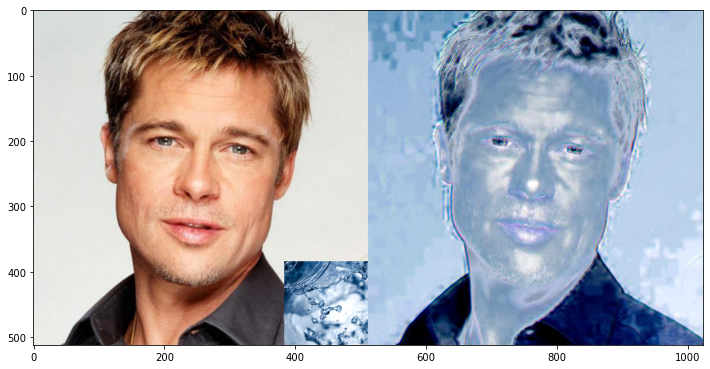

In [41]:
cPath= "./content/brad_pitt.jpg"
sPath = "./style/in1.jpg"
styletransfer(cPath,sPath)

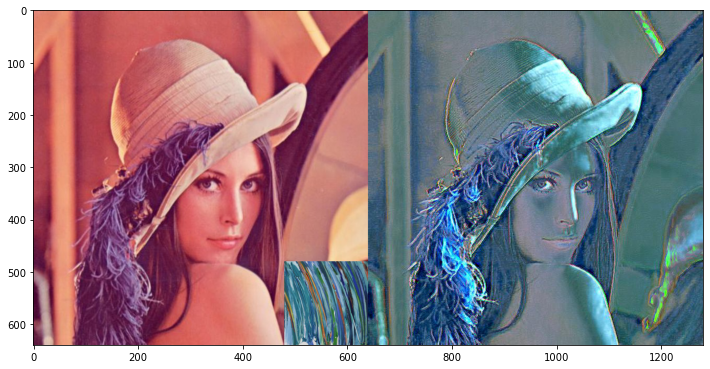

In [42]:
cPath= "./content/lenna.jpg"
sPath = "./style/brushstrokes.jpg"
styletransfer(cPath,sPath)

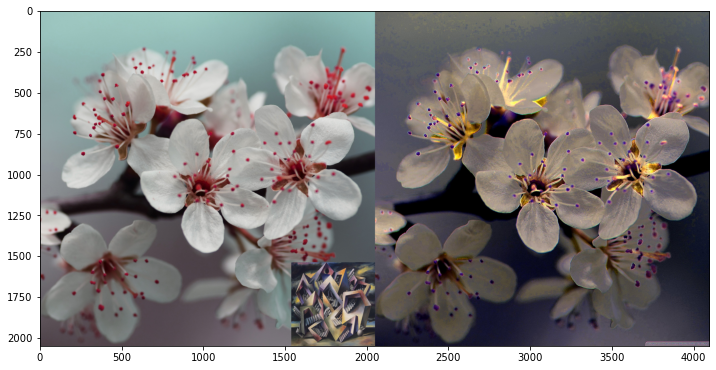

In [10]:
cPath= "./content/in1.jpg"
sPath = "./style/trial.jpg"
styletransfer(cPath,sPath)

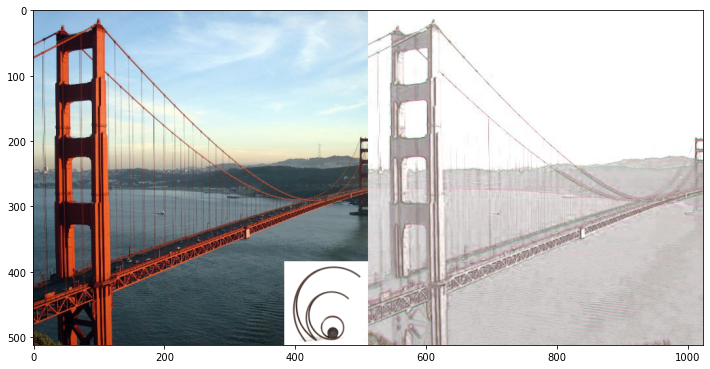

In [46]:
cPath= "./content/golden_gate.jpg"
sPath = "./style/in2.jpg"
styletransfer(cPath,sPath)